# EdgeFace PyTorch 모델을 ONNX로 변환 및 LFW 평가

이 노트북은 EdgeFace PyTorch 모델을 ONNX 형식으로 변환하고, LFW 데이터셋으로 평가하여 성능 변화를 확인합니다.

## 목차
1. 환경 설정 및 필요한 라이브러리 임포트
2. EdgeFace 모델 로드
3. PyTorch 모델을 ONNX로 변환
4. ONNX 모델 검증
5. LFW 데이터셋으로 PyTorch 모델 평가
6. LFW 데이터셋으로 ONNX 모델 평가
7. 성능 비교 및 결과 분석

## 1. 환경 설정 및 필요한 라이브러리 임포트

In [13]:
import os
import sys
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# PyTorch 관련
import torch
import torch.nn.functional as F
from torchvision import transforms

# ONNX 관련
import onnx
import onnxruntime as ort

# EdgeFace 백본 모델 임포트
sys.path.insert(0, os.path.dirname(os.path.abspath('')))
from backbones import get_model

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX version: {onnx.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu128
ONNX version: 1.19.1
ONNX Runtime version: 1.19.2
Using device: cuda


## 2. EdgeFace 모델 로드

사전 학습된 EdgeFace 모델을 로드합니다. `edgeface_xs_gamma_06` 모델을 사용합니다.

In [14]:
# 모델 설정
model_name = 'edgeface_xs_gamma_06'
checkpoint_path = 'checkpoints/edgeface_xs_gamma_06.pt'

# 모델 아키텍처 생성
print(f"Loading model architecture: {model_name}")
model = get_model(model_name)

# 체크포인트 로드
print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

# state_dict 추출
if isinstance(checkpoint, dict):
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
else:
    state_dict = checkpoint

# 모델에 가중치 로드
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Model architecture: {model_name}")

# 모델 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")

Loading model architecture: edgeface_xs_gamma_06
Loading checkpoint from: checkpoints/edgeface_xs_gamma_06.pt
Model loaded successfully!
Model architecture: edgeface_xs_gamma_06
Total parameters: 1,770,492 (1.77M)


## 3. PyTorch 모델을 ONNX로 변환

PyTorch 모델을 ONNX 형식으로 변환합니다. EdgeFace는 112x112 크기의 RGB 이미지를 입력으로 받습니다.

In [15]:
# ONNX 출력 경로
onnx_output_path = f'checkpoints/{model_name}.onnx'

# 더미 입력 생성 (배치 크기 1, 채널 3, 높이 112, 너비 112)
dummy_input = torch.randn(1, 3, 112, 112, device=device)

# ONNX로 변환
print(f"Converting model to ONNX format...")
print(f"Input shape: {dummy_input.shape}")

torch.onnx.export(
    model,                          # 변환할 모델
    dummy_input,                    # 더미 입력
    onnx_output_path,               # 출력 경로
    export_params=True,             # 학습된 파라미터를 파일에 저장
    opset_version=11,               # ONNX opset 버전
    do_constant_folding=True,       # 상수 폴딩 최적화
    input_names=['input.1'],        # 입력 이름 (calibration config와 일치)
    output_names=['output'],        # 출력 이름
    dynamic_axes={
        'input.1': {0: 'batch_size'},   # 배치 크기를 동적으로 설정
        'output': {0: 'batch_size'}
    }
)

print(f"Model successfully converted to ONNX!")
print(f"ONNX model saved to: {onnx_output_path}")

# 파일 크기 확인
file_size = os.path.getsize(onnx_output_path) / (1024 * 1024)
print(f"ONNX model size: {file_size:.2f} MB")

/tmp/ipykernel_30635/574564823.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Converting model to ONNX format...
Input shape: torch.Size([1, 3, 112, 112])
Model successfully converted to ONNX!
ONNX model saved to: checkpoints/edgeface_xs_gamma_06.onnx
ONNX model size: 6.98 MB


## 4. ONNX 모델 검증

변환된 ONNX 모델의 유효성을 검증하고, PyTorch 모델과 출력이 일치하는지 확인합니다.

In [16]:
# ONNX 모델 로드 및 검증
print("Validating ONNX model...")
onnx_model = onnx.load(onnx_output_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

# 모델 정보 출력
print("\nModel inputs:")
for input_tensor in onnx_model.graph.input:
    print(f"  Name: {input_tensor.name}")
    dims = [dim.dim_value if dim.dim_value > 0 else 'dynamic' for dim in input_tensor.type.tensor_type.shape.dim]
    print(f"  Shape: {dims}")

print("\nModel outputs:")
for output_tensor in onnx_model.graph.output:
    print(f"  Name: {output_tensor.name}")
    dims = [dim.dim_value if dim.dim_value > 0 else 'dynamic' for dim in output_tensor.type.tensor_type.shape.dim]
    print(f"  Shape: {dims}")

Validating ONNX model...
ONNX model is valid!

Model inputs:
  Name: input.1
  Shape: ['dynamic', 3, 112, 112]

Model outputs:
  Name: output
  Shape: ['dynamic', 512]


In [17]:
# ONNX Runtime 세션 생성
print("\nCreating ONNX Runtime session...")
ort_session = ort.InferenceSession(onnx_output_path)

# 테스트 입력 생성
test_input = torch.randn(1, 3, 112, 112, device=device)

# PyTorch 모델 출력
with torch.no_grad():
    pytorch_output = model(test_input)
    if isinstance(pytorch_output, tuple):
        pytorch_output = pytorch_output[0]
    pytorch_output = pytorch_output.cpu().numpy()

# ONNX 모델 출력
ort_inputs = {ort_session.get_inputs()[0].name: test_input.cpu().numpy()}
onnx_output = ort_session.run(None, ort_inputs)[0]

# 출력 비교
print(f"\nPyTorch output shape: {pytorch_output.shape}")
print(f"ONNX output shape: {onnx_output.shape}")

# 차이 계산
max_diff = np.max(np.abs(pytorch_output - onnx_output))
mean_diff = np.mean(np.abs(pytorch_output - onnx_output))
cosine_sim = np.dot(pytorch_output.flatten(), onnx_output.flatten()) / \
             (np.linalg.norm(pytorch_output) * np.linalg.norm(onnx_output))

print(f"\nOutput comparison:")
print(f"  Max difference: {max_diff:.8f}")
print(f"  Mean difference: {mean_diff:.8f}")
print(f"  Cosine similarity: {cosine_sim:.8f}")

if max_diff < 1e-4:
    print("\n✓ ONNX model outputs match PyTorch model (within tolerance)")
else:
    print(f"\n⚠ Warning: Large difference detected (max diff: {max_diff})")


Creating ONNX Runtime session...

PyTorch output shape: (1, 512)
ONNX output shape: (1, 512)

Output comparison:
  Max difference: 0.00001770
  Mean difference: 0.00000434
  Cosine similarity: 0.99999988

✓ ONNX model outputs match PyTorch model (within tolerance)


## 5. LFW 데이터셋으로 PyTorch 모델 평가

원본 PyTorch 모델의 성능을 LFW 데이터셋으로 평가합니다.

In [18]:
# LFW 데이터셋 경로 설정
lfw_dir = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled"
pairs_file = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv"

# 경로가 존재하는지 확인
if not os.path.exists(lfw_dir):
    print(f"⚠ Warning: LFW directory not found at {lfw_dir}")
    print("Please update the path to your LFW dataset")
else:
    print(f"✓ LFW directory found: {lfw_dir}")

if not os.path.exists(pairs_file):
    print(f"⚠ Warning: Pairs file not found at {pairs_file}")
    print("Please update the path to your pairs file")
else:
    print(f"✓ Pairs file found: {pairs_file}")

✓ LFW directory found: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled
✓ Pairs file found: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv


In [19]:
def load_lfw_pairs(pairs_file: str, lfw_dir: str) -> List[Tuple]:
    """
    LFW pairs 파일을 로드합니다.
    
    Args:
        pairs_file: pairs.txt 또는 pairs.csv 파일 경로
        lfw_dir: LFW 데이터셋 디렉토리
    
    Returns:
        List of (is_same, img1_path, img2_path) tuples
    """
    pairs = []
    
    if pairs_file.endswith('.csv'):
        # CSV 형식 처리
        with open(pairs_file, 'r') as f:
            lines = f.readlines()[1:]  # 헤더 스킵
        
        for line in lines:
            line = line.strip()
            if not line:
                continue
            
            if line.endswith(','):
                # 같은 사람 쌍: name,img1,img2,
                parts = line.rstrip(',').split(',')
                if len(parts) == 3:
                    try:
                        person = parts[0]
                        img1_num = int(parts[1])
                        img2_num = int(parts[2])
                        
                        img1_path = os.path.join(lfw_dir, person, f"{person}_{img1_num:04d}.jpg")
                        img2_path = os.path.join(lfw_dir, person, f"{person}_{img2_num:04d}.jpg")
                        pairs.append((True, img1_path, img2_path))
                    except ValueError:
                        continue
            else:
                # 다른 사람 쌍: name1,img1,name2,img2
                parts = line.split(',')
                if len(parts) == 4:
                    try:
                        person1 = parts[0]
                        img1_num = int(parts[1])
                        person2 = parts[2]
                        img2_num = int(parts[3])
                        
                        img1_path = os.path.join(lfw_dir, person1, f"{person1}_{img1_num:04d}.jpg")
                        img2_path = os.path.join(lfw_dir, person2, f"{person2}_{img2_num:04d}.jpg")
                        pairs.append((False, img1_path, img2_path))
                    except ValueError:
                        continue
    else:
        # TXT 형식 처리
        with open(pairs_file, 'r') as f:
            lines = f.readlines()[1:]  # 헤더 스킵
        
        for line in lines:
            parts = line.strip().split('\t')
            
            if len(parts) == 3:
                # 같은 사람 쌍
                person, img1_num, img2_num = parts
                img1_path = os.path.join(lfw_dir, person, f"{person}_{img1_num:04d}.jpg")
                img2_path = os.path.join(lfw_dir, person, f"{person}_{img2_num:04d}.jpg")
                pairs.append((True, img1_path, img2_path))
            elif len(parts) == 4:
                # 다른 사람 쌍
                person1, img1_num, person2, img2_num = parts
                img1_path = os.path.join(lfw_dir, person1, f"{person1}_{img1_num:04d}.jpg")
                img2_path = os.path.join(lfw_dir, person2, f"{person2}_{img2_num:04d}.jpg")
                pairs.append((False, img1_path, img2_path))
    
    return pairs

# Pairs 로드
if os.path.exists(pairs_file):
    pairs = load_lfw_pairs(pairs_file, lfw_dir)
    print(f"Loaded {len(pairs)} pairs from LFW")
    
    # 통계 확인
    positive_pairs = sum(1 for p in pairs if p[0])
    negative_pairs = len(pairs) - positive_pairs
    print(f"  Positive pairs (same person): {positive_pairs}")
    print(f"  Negative pairs (different person): {negative_pairs}")

Loaded 6000 pairs from LFW
  Positive pairs (same person): 3000
  Negative pairs (different person): 3000


In [20]:
def preprocess_face_pytorch(img: Image.Image) -> torch.Tensor:
    """
    PyTorch 모델을 위한 얼굴 이미지 전처리
    
    Args:
        img: PIL Image (RGB)
    
    Returns:
        전처리된 텐서 (1, 3, 112, 112)
    """
    # RGB 포맷 확인
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # 112x112로 리사이즈
    img = img.resize((112, 112), Image.LANCZOS)
    
    # 정규화 변환
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    
    # 배치 차원 추가
    input_tensor = transform(img).unsqueeze(0)
    
    return input_tensor

def extract_embedding_pytorch(img: Image.Image, model: torch.nn.Module, device: str) -> np.ndarray:
    """
    PyTorch 모델을 사용하여 임베딩 추출
    
    Args:
        img: PIL Image
        model: PyTorch 모델
        device: 디바이스
    
    Returns:
        임베딩 벡터 (numpy array)
    """
    # 전처리
    input_tensor = preprocess_face_pytorch(img).to(device)
    
    # 임베딩 추출
    with torch.no_grad():
        embedding = model(input_tensor)
        if isinstance(embedding, tuple):
            embedding = embedding[0]
        embedding = embedding.cpu().numpy().flatten()
    
    return embedding

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [12]:
def evaluate_model_pytorch(pairs: List[Tuple], model: torch.nn.Module, device: str, 
                          max_pairs: Optional[int] = None) -> dict:
    """
    PyTorch 모델을 LFW 데이터셋으로 평가
    
    Args:
        pairs: LFW pairs
        model: PyTorch 모델
        device: 디바이스
        max_pairs: 평가할 최대 페어 수 (테스트용)
    
    Returns:
        평가 결과 딕셔너리
    """
    similarities = []
    labels = []
    processing_times = []
    failed_count = 0
    
    # 평가할 페어 선택
    if max_pairs:
        positive_pairs = [p for p in pairs if p[0] == True]
        negative_pairs = [p for p in pairs if p[0] == False]
        
        half_pairs = max_pairs // 2
        selected_positive = positive_pairs[:half_pairs]
        selected_negative = negative_pairs[:half_pairs]
        
        pairs_to_process = selected_positive + selected_negative
        print(f"Evaluating {len(selected_positive)} positive and {len(selected_negative)} negative pairs")
    else:
        pairs_to_process = pairs
    
    print(f"\nEvaluating PyTorch model on {len(pairs_to_process)} pairs...")
    
    for is_same, img1_path, img2_path in tqdm(pairs_to_process, desc="Processing pairs"):
        # 이미지 존재 확인
        if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
            failed_count += 1
            continue
        
        start_time = time.time()
        
        try:
            # 이미지 로드
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
            
            # 임베딩 추출
            emb1 = extract_embedding_pytorch(img1, model, device)
            emb2 = extract_embedding_pytorch(img2, model, device)
            
            # 코사인 유사도 계산
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similarities.append(similarity)
            labels.append(1 if is_same else 0)
            
            processing_times.append(time.time() - start_time)
            
        except Exception as e:
            failed_count += 1
            continue
    
    # 결과 계산
    similarities = np.array(similarities)
    labels = np.array(labels)
    
    if len(similarities) == 0:
        print("No valid pairs processed!")
        return None
    
    # ROC 커브
    fpr, tpr, thresholds = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)
    
    # 최적 임계값 찾기 (정확도 최대화)
    accuracies = []
    for threshold in thresholds:
        predictions = (similarities >= threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        accuracies.append(accuracy)
    
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]
    
    # EER (Equal Error Rate)
    eer_idx = np.nanargmin(np.absolute(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    
    results = {
        'num_pairs': len(similarities),
        'failed_pairs': failed_count,
        'success_rate': len(similarities) / len(pairs_to_process),
        'roc_auc': roc_auc,
        'best_accuracy': best_accuracy,
        'best_threshold': best_threshold,
        'eer': eer,
        'avg_processing_time': np.mean(processing_times),
        'std_processing_time': np.std(processing_times),
        'similarities': similarities,
        'labels': labels,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }
    
    return results

# PyTorch 모델 평가
if os.path.exists(pairs_file):
    pytorch_results = evaluate_model_pytorch(pairs, model, device, max_pairs=None)  # 전체 평가
    
    if pytorch_results:
        print(f"\n=== PyTorch Model Results ===")
        print(f"Pairs processed: {pytorch_results['num_pairs']}")
        print(f"Success rate: {pytorch_results['success_rate']:.4f}")
        print(f"ROC AUC: {pytorch_results['roc_auc']:.4f}")
        print(f"Best Accuracy: {pytorch_results['best_accuracy']:.4f}")
        print(f"Best Threshold: {pytorch_results['best_threshold']:.4f}")
        print(f"EER: {pytorch_results['eer']:.4f}")
        print(f"Avg Processing Time: {pytorch_results['avg_processing_time']:.4f}s")


Evaluating PyTorch model on 6000 pairs...


Processing pairs: 100%|██████████| 6000/6000 [02:47<00:00, 35.81it/s]


=== PyTorch Model Results ===
Pairs processed: 6000
Success rate: 1.0000
ROC AUC: 0.8731
Best Accuracy: 0.8037
Best Threshold: 0.4881
EER: 0.2043
Avg Processing Time: 0.0235s


## 6. LFW 데이터셋으로 ONNX 모델 평가

ONNX로 변환된 모델의 성능을 평가합니다. (alignment 과정은 생략)

In [21]:
def preprocess_face_onnx(img: Image.Image) -> np.ndarray:
    """
    ONNX 모델을 위한 얼굴 이미지 전처리
    
    Args:
        img: PIL Image (RGB)
    
    Returns:
        전처리된 numpy array (1, 3, 112, 112)
    """
    # RGB 포맷 확인
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # 112x112로 리사이즈
    img = img.resize((112, 112), Image.LANCZOS)
    
    # numpy array로 변환
    img_array = np.array(img).astype(np.float32)
    
    # [0, 255] -> [0, 1]
    img_array = img_array / 255.0
    
    # 정규화: mean=0.5, std=0.5
    img_array = (img_array - 0.5) / 0.5
    
    # HWC -> CHW
    img_array = np.transpose(img_array, (2, 0, 1))
    
    # 배치 차원 추가
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def extract_embedding_onnx(img: Image.Image, session: ort.InferenceSession) -> np.ndarray:
    """
    ONNX 모델을 사용하여 임베딩 추출
    
    Args:
        img: PIL Image
        session: ONNX Runtime 세션
    
    Returns:
        임베딩 벡터 (numpy array)
    """
    # 전처리
    input_array = preprocess_face_onnx(img)
    
    # 임베딩 추출
    ort_inputs = {session.get_inputs()[0].name: input_array}
    embedding = session.run(None, ort_inputs)[0]
    embedding = embedding.flatten()
    
    return embedding

print("ONNX preprocessing functions defined.")

ONNX preprocessing functions defined.


In [22]:
def evaluate_model_onnx(pairs: List[Tuple], session: ort.InferenceSession,
                       max_pairs: Optional[int] = None) -> dict:
    """
    ONNX 모델을 LFW 데이터셋으로 평가
    
    Args:
        pairs: LFW pairs
        session: ONNX Runtime 세션
        max_pairs: 평가할 최대 페어 수 (테스트용)
    
    Returns:
        평가 결과 딕셔너리
    """
    similarities = []
    labels = []
    processing_times = []
    failed_count = 0
    
    # 평가할 페어 선택
    if max_pairs:
        positive_pairs = [p for p in pairs if p[0] == True]
        negative_pairs = [p for p in pairs if p[0] == False]
        
        half_pairs = max_pairs // 2
        selected_positive = positive_pairs[:half_pairs]
        selected_negative = negative_pairs[:half_pairs]
        
        pairs_to_process = selected_positive + selected_negative
        print(f"Evaluating {len(selected_positive)} positive and {len(selected_negative)} negative pairs")
    else:
        pairs_to_process = pairs
    
    print(f"\nEvaluating ONNX model on {len(pairs_to_process)} pairs...")
    
    for is_same, img1_path, img2_path in tqdm(pairs_to_process, desc="Processing pairs"):
        # 이미지 존재 확인
        if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
            failed_count += 1
            continue
        
        start_time = time.time()
        
        try:
            # 이미지 로드
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
            
            # 임베딩 추출
            emb1 = extract_embedding_onnx(img1, session)
            emb2 = extract_embedding_onnx(img2, session)
            
            # 코사인 유사도 계산
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similarities.append(similarity)
            labels.append(1 if is_same else 0)
            
            processing_times.append(time.time() - start_time)
            
        except Exception as e:
            failed_count += 1
            continue
    
    # 결과 계산
    similarities = np.array(similarities)
    labels = np.array(labels)
    
    if len(similarities) == 0:
        print("No valid pairs processed!")
        return None
    
    # ROC 커브
    fpr, tpr, thresholds = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)
    
    # 최적 임계값 찾기 (정확도 최대화)
    accuracies = []
    for threshold in thresholds:
        predictions = (similarities >= threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        accuracies.append(accuracy)
    
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]
    
    # EER (Equal Error Rate)
    eer_idx = np.nanargmin(np.absolute(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    
    results = {
        'num_pairs': len(similarities),
        'failed_pairs': failed_count,
        'success_rate': len(similarities) / len(pairs_to_process),
        'roc_auc': roc_auc,
        'best_accuracy': best_accuracy,
        'best_threshold': best_threshold,
        'eer': eer,
        'avg_processing_time': np.mean(processing_times),
        'std_processing_time': np.std(processing_times),
        'similarities': similarities,
        'labels': labels,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }
    
    return results

# ONNX 모델 평가
if os.path.exists(pairs_file) and os.path.exists(onnx_output_path):
    onnx_results = evaluate_model_onnx(pairs, ort_session, max_pairs=None)  # 전체 평가
    
    if onnx_results:
        print(f"\n=== ONNX Model Results ===")
        print(f"Pairs processed: {onnx_results['num_pairs']}")
        print(f"Success rate: {onnx_results['success_rate']:.4f}")
        print(f"ROC AUC: {onnx_results['roc_auc']:.4f}")
        print(f"Best Accuracy: {onnx_results['best_accuracy']:.4f}")
        print(f"Best Threshold: {onnx_results['best_threshold']:.4f}")
        print(f"EER: {onnx_results['eer']:.4f}")
        print(f"Avg Processing Time: {onnx_results['avg_processing_time']:.4f}s")


Evaluating ONNX model on 6000 pairs...


Processing pairs: 100%|██████████| 6000/6000 [01:47<00:00, 56.05it/s]


=== ONNX Model Results ===
Pairs processed: 6000
Success rate: 1.0000
ROC AUC: 0.8731
Best Accuracy: 0.8037
Best Threshold: 0.4881
EER: 0.2043
Avg Processing Time: 0.0133s


## 7. 성능 비교 및 결과 분석

PyTorch 모델과 ONNX 모델의 성능을 비교하고 시각화합니다.

In [27]:
# 성능 비교 테이블 생성
if pytorch_results and onnx_results:
    comparison_df = pd.DataFrame({
        'Metric': ['ROC AUC', 'Best Accuracy', 'EER', 'Avg Processing Time (s)'],
        'PyTorch': [
            f"{pytorch_results['roc_auc']:.4f}",
            f"{pytorch_results['best_accuracy']:.4f}",
            f"{pytorch_results['eer']:.4f}",
            f"{pytorch_results['avg_processing_time']:.4f}"
        ],
        'ONNX': [
            f"{onnx_results['roc_auc']:.4f}",
            f"{onnx_results['best_accuracy']:.4f}",
            f"{onnx_results['eer']:.4f}",
            f"{onnx_results['avg_processing_time']:.4f}"
        ],
        'Difference': [
            f"{onnx_results['roc_auc'] - pytorch_results['roc_auc']:.4f}",
            f"{onnx_results['best_accuracy'] - pytorch_results['best_accuracy']:.4f}",
            f"{onnx_results['eer'] - pytorch_results['eer']:.4f}",
            f"{onnx_results['avg_processing_time'] - pytorch_results['avg_processing_time']:.4f}"
        ]
    })
    
    print("\n=== Performance Comparison ===")
    print(comparison_df.to_string(index=False))
    
    # CSV로 저장
    comparison_df.to_csv('pytorch_vs_onnx_comparison.csv', index=False)
    print("\nComparison saved to: pytorch_vs_onnx_comparison.csv")


=== Performance Comparison ===
                 Metric PyTorch   ONNX Difference
                ROC AUC  0.8731 0.8731     0.0000
          Best Accuracy  0.8037 0.8037     0.0000
                    EER  0.2043 0.2043     0.0000
Avg Processing Time (s)  0.0235 0.0133    -0.0102

Comparison saved to: pytorch_vs_onnx_comparison.csv


ROC curves saved to: pytorch_vs_onnx_roc_curves.png


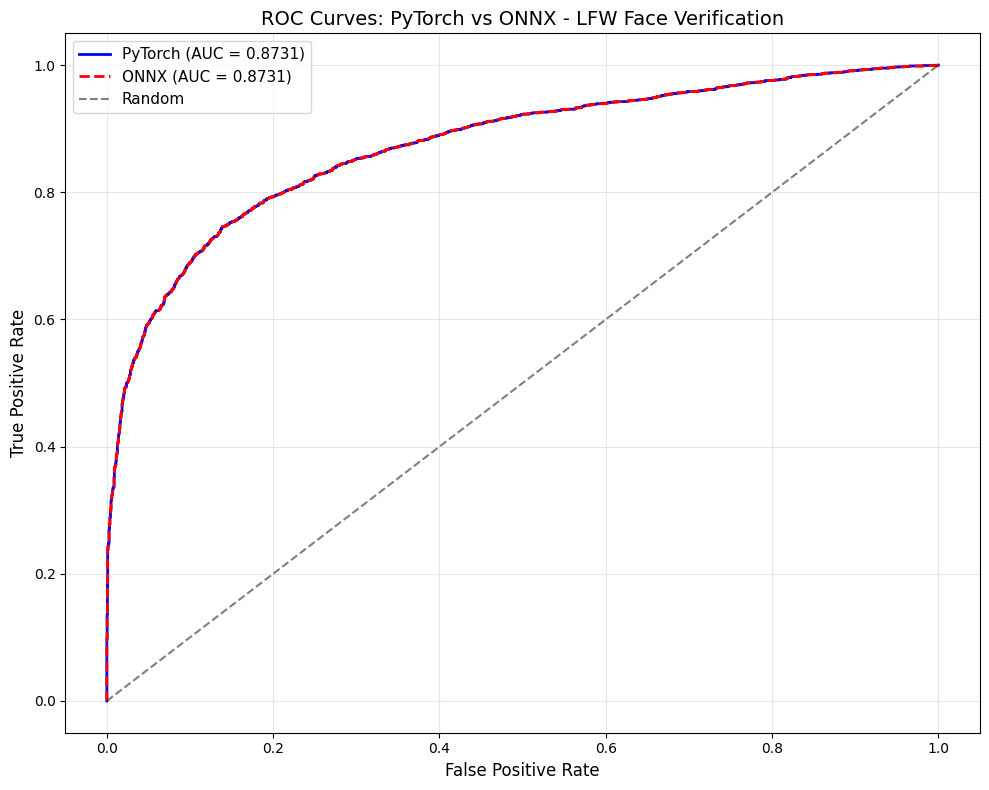

In [24]:
# ROC 커브 비교 플롯
if pytorch_results and onnx_results:
    plt.figure(figsize=(10, 8))
    
    # PyTorch ROC curve
    plt.plot(pytorch_results['fpr'], pytorch_results['tpr'], 
             label=f"PyTorch (AUC = {pytorch_results['roc_auc']:.4f})", 
             linewidth=2, color='blue')
    
    # ONNX ROC curve
    plt.plot(onnx_results['fpr'], onnx_results['tpr'], 
             label=f"ONNX (AUC = {onnx_results['roc_auc']:.4f})", 
             linewidth=2, color='red', linestyle='--')
    
    # Random baseline
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves: PyTorch vs ONNX - LFW Face Verification', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig('pytorch_vs_onnx_roc_curves.png', dpi=300, bbox_inches='tight')
    print("ROC curves saved to: pytorch_vs_onnx_roc_curves.png")
    plt.show()

Metrics comparison saved to: pytorch_vs_onnx_metrics.png


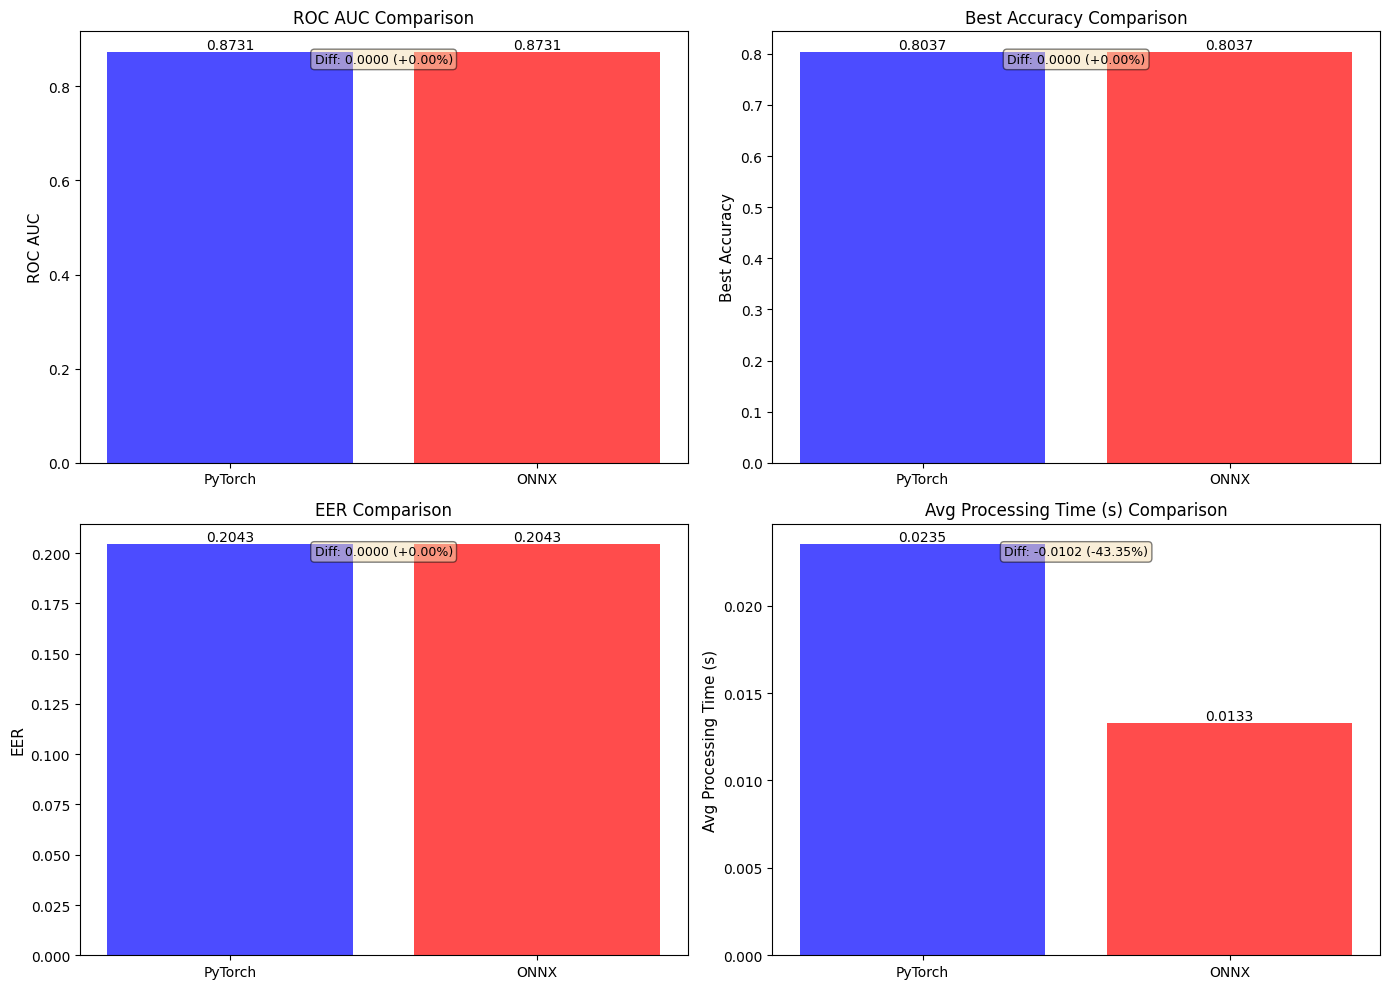

In [25]:
# 성능 메트릭 비교 막대 그래프
if pytorch_results and onnx_results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics = [
        ('ROC AUC', 'roc_auc', axes[0, 0]),
        ('Best Accuracy', 'best_accuracy', axes[0, 1]),
        ('EER', 'eer', axes[1, 0]),
        ('Avg Processing Time (s)', 'avg_processing_time', axes[1, 1])
    ]
    
    for metric_name, metric_key, ax in metrics:
        pytorch_val = pytorch_results[metric_key]
        onnx_val = onnx_results[metric_key]
        
        bars = ax.bar(['PyTorch', 'ONNX'], [pytorch_val, onnx_val], 
                      color=['blue', 'red'], alpha=0.7)
        
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} Comparison', fontsize=12)
        
        # 값 레이블 추가
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10)
        
        # 차이 표시
        diff = onnx_val - pytorch_val
        diff_pct = (diff / pytorch_val * 100) if pytorch_val != 0 else 0
        ax.text(0.5, 0.95, f'Diff: {diff:.4f} ({diff_pct:+.2f}%)',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=9)
    
    plt.tight_layout()
    plt.savefig('pytorch_vs_onnx_metrics.png', dpi=300, bbox_inches='tight')
    print("Metrics comparison saved to: pytorch_vs_onnx_metrics.png")
    plt.show()

Similarity distributions saved to: pytorch_vs_onnx_similarity_distributions.png


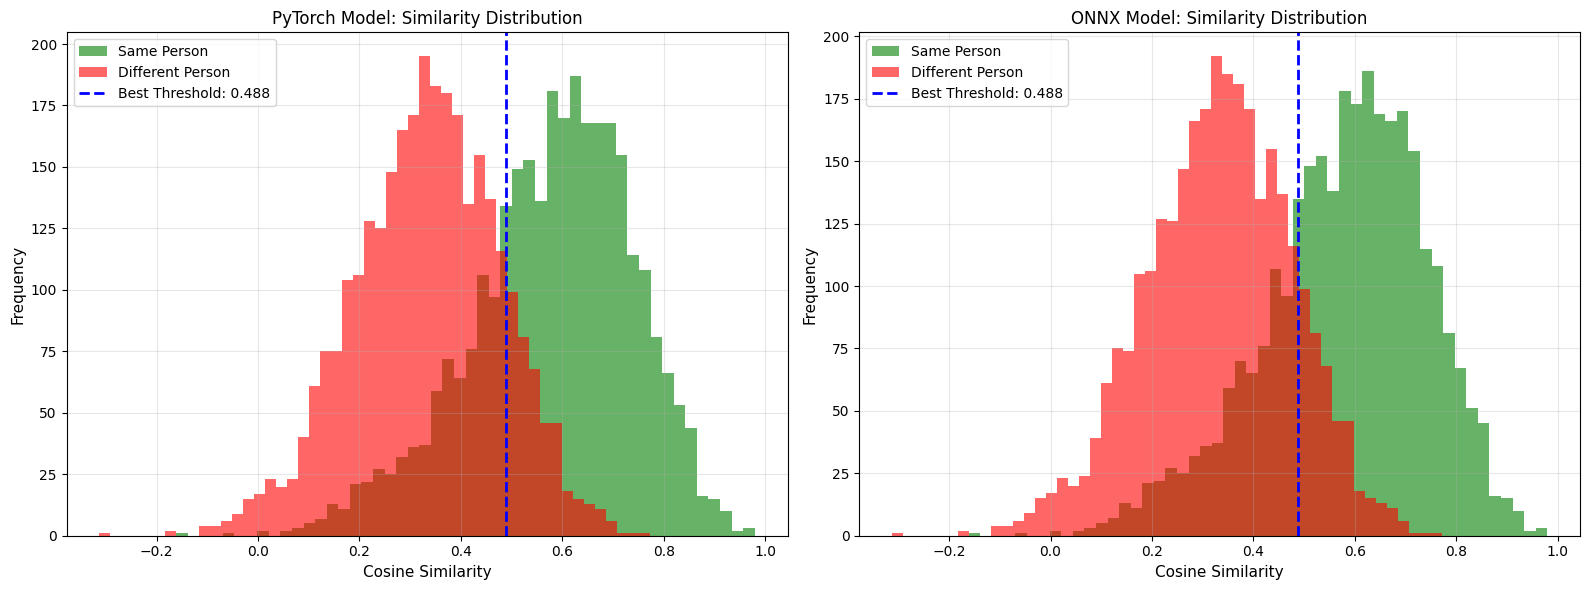

In [26]:
# 유사도 분포 비교
if pytorch_results and onnx_results:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # PyTorch 유사도 분포
    ax = axes[0]
    pos_sims_pt = pytorch_results['similarities'][pytorch_results['labels'] == 1]
    neg_sims_pt = pytorch_results['similarities'][pytorch_results['labels'] == 0]
    
    ax.hist(pos_sims_pt, bins=50, alpha=0.6, label='Same Person', color='green')
    ax.hist(neg_sims_pt, bins=50, alpha=0.6, label='Different Person', color='red')
    ax.axvline(pytorch_results['best_threshold'], color='blue', linestyle='--', 
               linewidth=2, label=f"Best Threshold: {pytorch_results['best_threshold']:.3f}")
    ax.set_xlabel('Cosine Similarity', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('PyTorch Model: Similarity Distribution', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ONNX 유사도 분포
    ax = axes[1]
    pos_sims_onnx = onnx_results['similarities'][onnx_results['labels'] == 1]
    neg_sims_onnx = onnx_results['similarities'][onnx_results['labels'] == 0]
    
    ax.hist(pos_sims_onnx, bins=50, alpha=0.6, label='Same Person', color='green')
    ax.hist(neg_sims_onnx, bins=50, alpha=0.6, label='Different Person', color='red')
    ax.axvline(onnx_results['best_threshold'], color='blue', linestyle='--', 
               linewidth=2, label=f"Best Threshold: {onnx_results['best_threshold']:.3f}")
    ax.set_xlabel('Cosine Similarity', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('ONNX Model: Similarity Distribution', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pytorch_vs_onnx_similarity_distributions.png', dpi=300, bbox_inches='tight')
    print("Similarity distributions saved to: pytorch_vs_onnx_similarity_distributions.png")
    plt.show()

## 결론

위 분석을 통해 다음을 확인할 수 있습니다:

1. **정확도 비교**: PyTorch 모델과 ONNX 모델의 ROC AUC, 정확도, EER 등의 메트릭을 비교하여 변환 후 성능 변화를 평가.

2. **처리 속도**: ONNX 모델의 추론 속도가 PyTorch 모델과 어떻게 다른지 확인.

3. **유사도 분포**: 두 모델의 유사도 분포를 비교하여 임베딩 품질이 유지되는지 확인.